In [8]:
!pip install jcopml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import collections

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,PolynomialFeatures,OneHotEncoder,OrdinalEncoder,PowerTransformer
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp, bayes_search_params as bsp
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_actual_vs_prediction,plot_classification_report,plot_confusion_matrix,plot_correlation_matrix,plot_residual

warnings.filterwarnings("ignore")

You should consider upgrading via the 'c:\users\mailt\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
df = pd.read_csv("audi.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


In [14]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


In [16]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,2017.100675,22896.685039,24827.244001,126.011436,50.770022,1.930709
std,2.167494,11714.841888,23505.257205,67.170294,12.949782,0.602957
min,1997.000000,1490.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,15130.750000,5968.750000,125.000000,40.900000,1.500000
50%,2017.000000,20200.000000,19000.000000,145.000000,49.600000,2.000000
75%,2019.000000,27990.000000,36464.500000,145.000000,58.900000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,188.300000,6.300000


In [17]:
df.describe(include='O')

,model,transmission,fuelType
count,10668,10668,10668
unique,26,3,3
top,A3,Manual,Diesel
freq,1929,4369,5577


In [18]:
for i in df[['model','transmission','fuelType']]:
    print("Unique Values Colums : ", i)
    print(df[i].unique())

Unique Values Colums :  model
[' A1' ' A6' ' A4' ' A3' ' Q3' ' Q5' ' A5' ' S4' ' Q2' ' A7' ' TT' ' Q7'
 ' RS6' ' RS3' ' A8' ' Q8' ' RS4' ' RS5' ' R8' ' SQ5' ' S8' ' SQ7' ' S3'
 ' S5' ' A2' ' RS7']
Unique Values Colums :  transmission
['Manual' 'Automatic' 'Semi-Auto']
Unique Values Colums :  fuelType
['Petrol' 'Diesel' 'Hybrid']


In [19]:
cat_mask = (df.dtypes == np.object)
num_mask = (df.dtypes == np.int64) | (df.dtypes == np.float64)

cols_cat = df.columns[cat_mask].to_list()
cols_num = df.columns[num_mask].to_list()

print(cols_cat)
print(cols_num)

['model', 'transmission', 'fuelType']
['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']


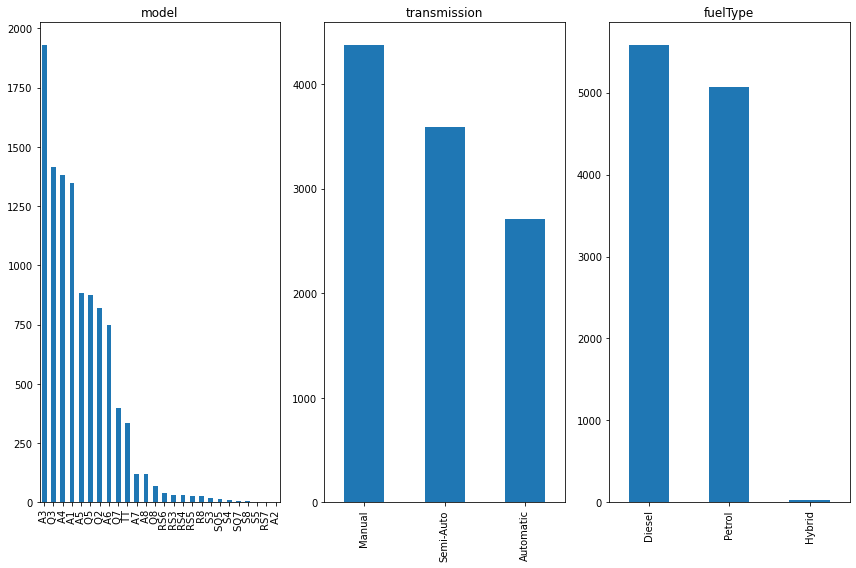

In [20]:
fig,axs = plt.subplots(ncols=3,figsize=(12,8))

for ax,i in zip(axs.flat, df[cols_cat]):
    df[i].value_counts().plot(kind='bar',ax=ax)
    ax.set_title(f'{df[i].name}')
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
plt.tight_layout()
plt.show()

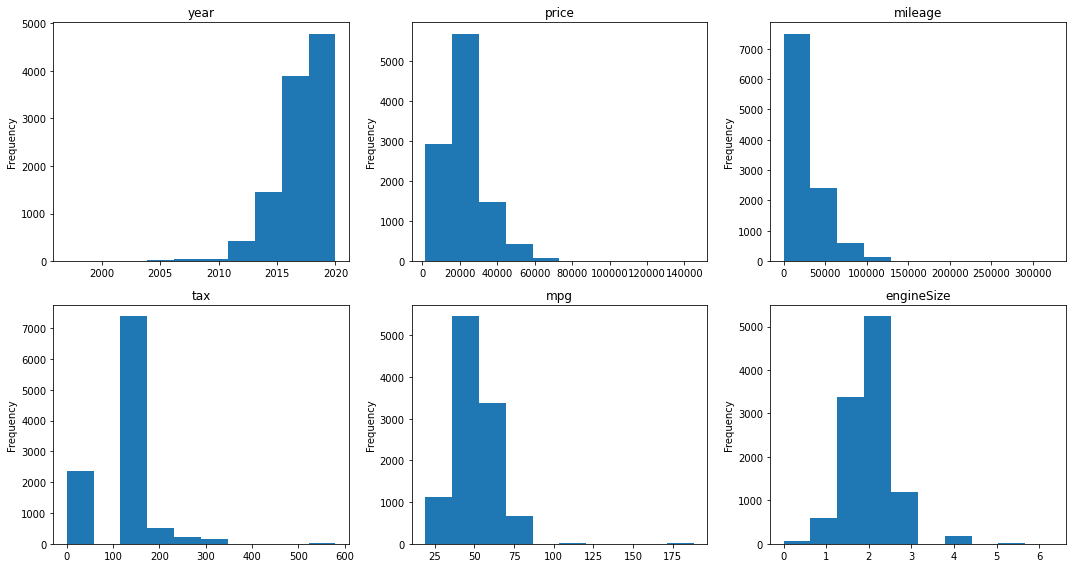

In [21]:
fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(15,8))

for ax,i in zip(axs.flat, df[cols_num]):
    df[i].plot(kind='hist',ax=ax, bins=10)
    ax.set_title(f'{df[i].name}')
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
plt.tight_layout()
plt.show()

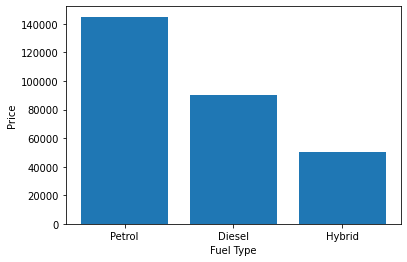

In [22]:
plt.bar(df['fuelType'],df['price'])
plt.xlabel("Fuel Type")
plt.ylabel("Price");

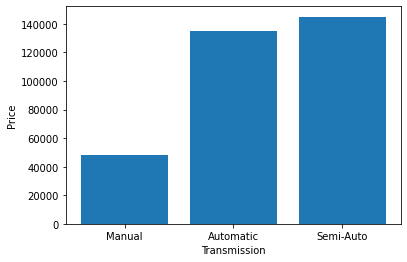

In [23]:
plt.bar(df['transmission'],df['price'])
plt.xlabel("Transmission")
plt.ylabel("Price");

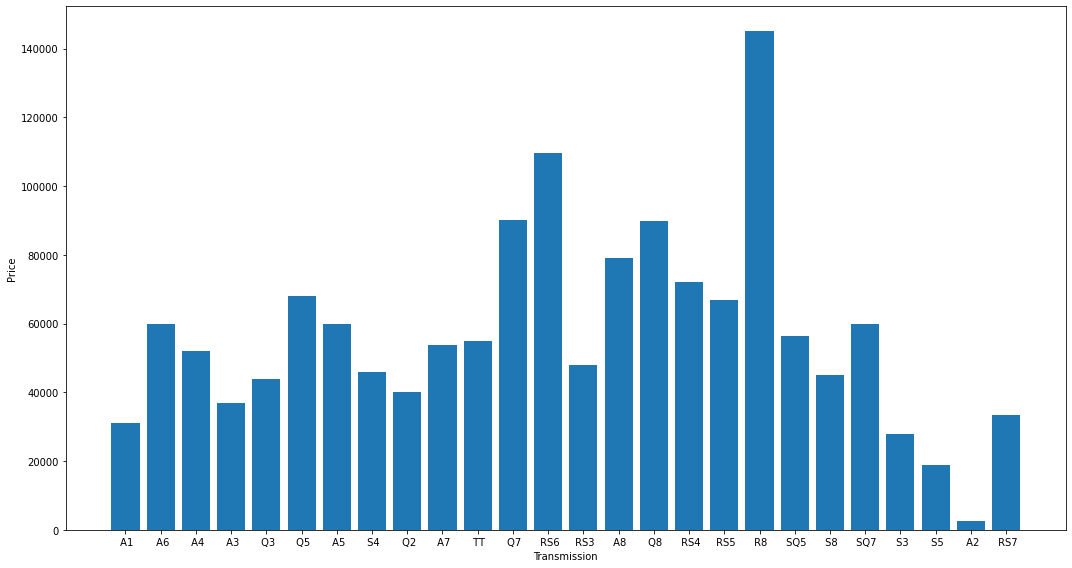

In [24]:
plt.figure(figsize=(15,8))
plt.bar(df['model'],df['price'])
plt.xlabel("Transmission")
plt.ylabel("Price")
plt.tight_layout();

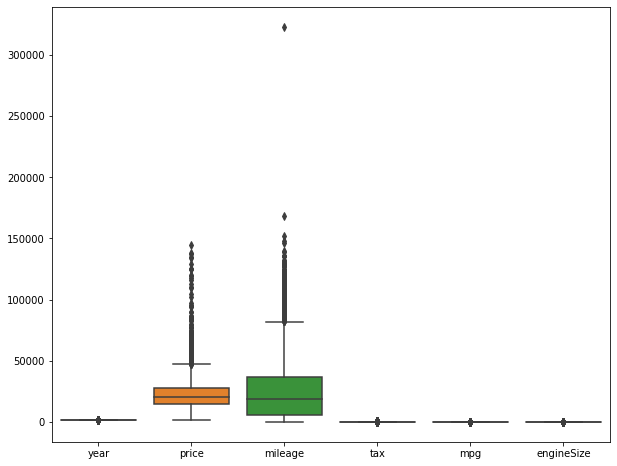

In [25]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df);

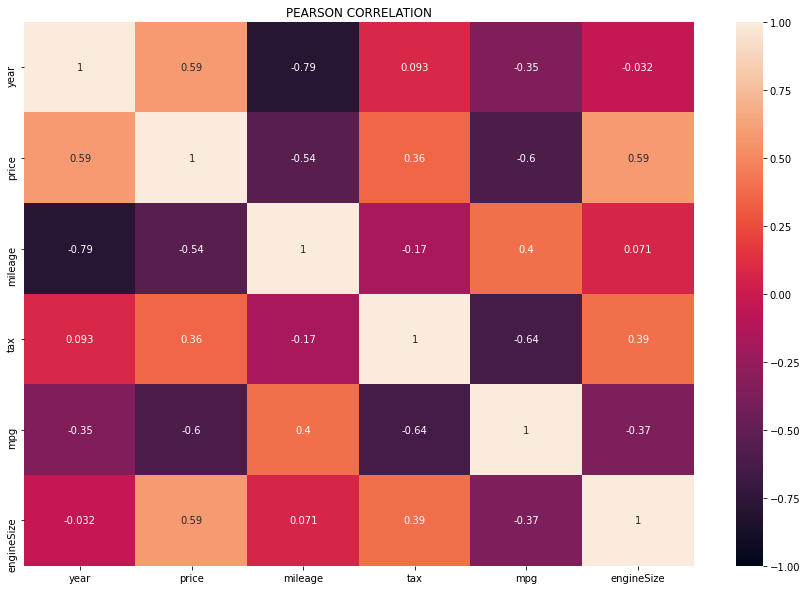

In [26]:
pearson_corr = df.corr()

figure = plt.figure(figsize=(15,10))
sns.heatmap(pearson_corr,annot=True, vmin=-1, vmax=+1)
plt.title("PEARSON CORRELATION")
plt.show()

In [27]:
pd.DataFrame({"skew":df[cols_num].skew(axis=0)})

,skew
year,-1.454814
price,2.277323
mileage,1.576429
tax,0.601686
mpg,1.832859
engineSize,1.212639


In [28]:
X = df.drop(columns='price')
y = df['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((7467, 8), (3201, 8), (7467,), (3201,))

In [30]:
num_pipe = Pipeline([("scaler",RobustScaler()),
                    ])

cat_pipe = Pipeline([("encoder",OneHotEncoder())
                    ])

ordinal_pipe = Pipeline([("encoder",OrdinalEncoder())])

preprosesor = ColumnTransformer([("numeric",num_pipe,['mileage','tax','mpg','engineSize']),
                                 ("categorical",cat_pipe,['transmission','fuelType']),])

In [31]:
pipeline = Pipeline([("prep",preprosesor),
                    ("algo",RandomForestRegressor(random_state=42))])

lr = GridSearchCV(pipeline,gsp.rf_params,cv=3,n_jobs=-1,verbose=1)
lr.fit(X_train,y_train)

# Evaluation
print(lr.best_params_)
print(lr.score(X_train,y_train),lr.best_score_,lr.score(X_test,y_test))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
0.9880691291323094 0.9189941568458687 0.9258116386341031


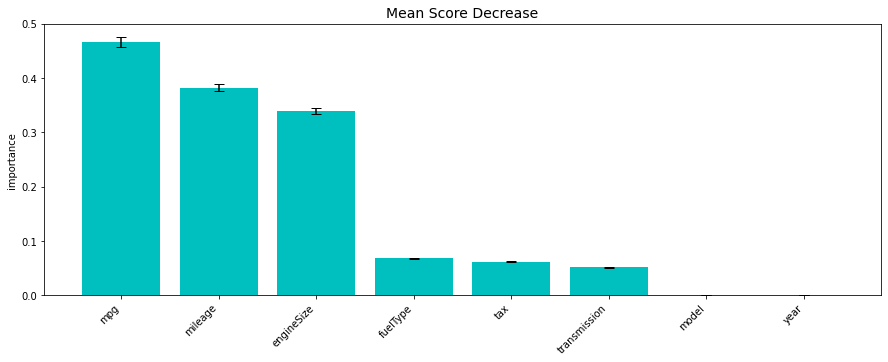

In [32]:
df_imp = mean_score_decrease(X_train, y_train, lr, plot=True, topk=10)

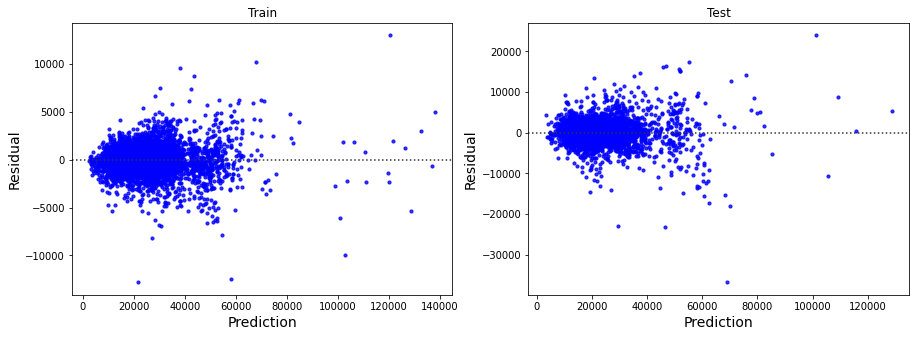

In [34]:
plot_residual(X_train, y_train, X_test, y_test, lr, lowess=False)

In [35]:
num_pipe = Pipeline([("scaler",RobustScaler()),
                    ("transform",PowerTransformer()),
                    ("poly",PolynomialFeatures(degree=2))])

cat_pipe = Pipeline([("encoder",OneHotEncoder())
                    ])

ordinal_pipe = Pipeline([("encoder",OrdinalEncoder())])

preprosesor = ColumnTransformer([("numeric",num_pipe,['mileage','mpg','engineSize'])])

pipeline = Pipeline([("prep",preprosesor),
                    ("algo",RandomForestRegressor(random_state=42))])

parameter = {'prep__numeric__poly__degree': [1, 2, 3],
             'prep__numeric__poly__interaction_only': [True, False],
             'algo__n_estimators': [100, 103, 105],
             'algo__max_depth': [10, 11, 12],
             'algo__max_features': [0.1, 0.11, 0.12],
             'algo__min_samples_leaf': [1, 3, 5]}


lr1 = GridSearchCV(pipeline,parameter,cv=3,n_jobs=-1,verbose=1)
lr1.fit(X_train,y_train)

# Evaluation
print(lr1.best_params_)
print(lr1.score(X_train,y_train),lr1.best_score_,lr1.score(X_test,y_test))

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
{'algo__max_depth': 11, 'algo__max_features': 0.1, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 105, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.948720548408145 0.908057388777483 0.9116221019247082


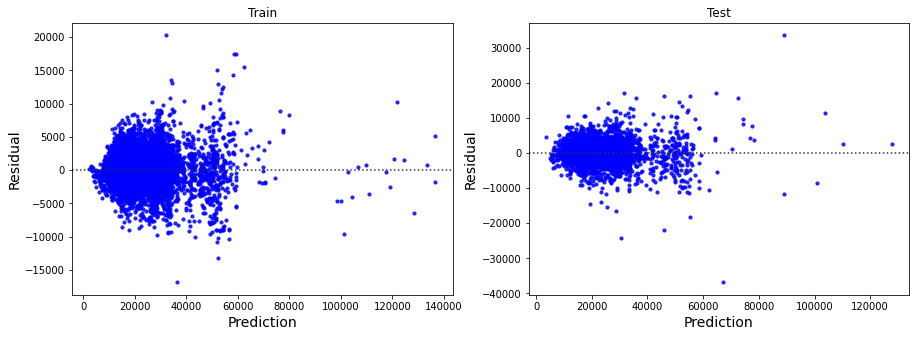

In [36]:
plot_residual(X_train, y_train, X_test, y_test, lr1, lowess=False)

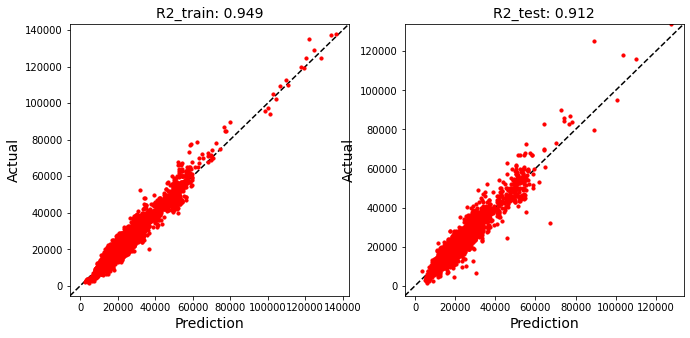

In [37]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, lr1)

In [38]:
y_pred = lr1.predict(X_test)
print("Mean Squared Error : ", mean_squared_error(y_test,y_pred))

Mean Squared Error :  12343485.274351954


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [40]:
data = pd.read_csv('audi.csv')

In [41]:
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


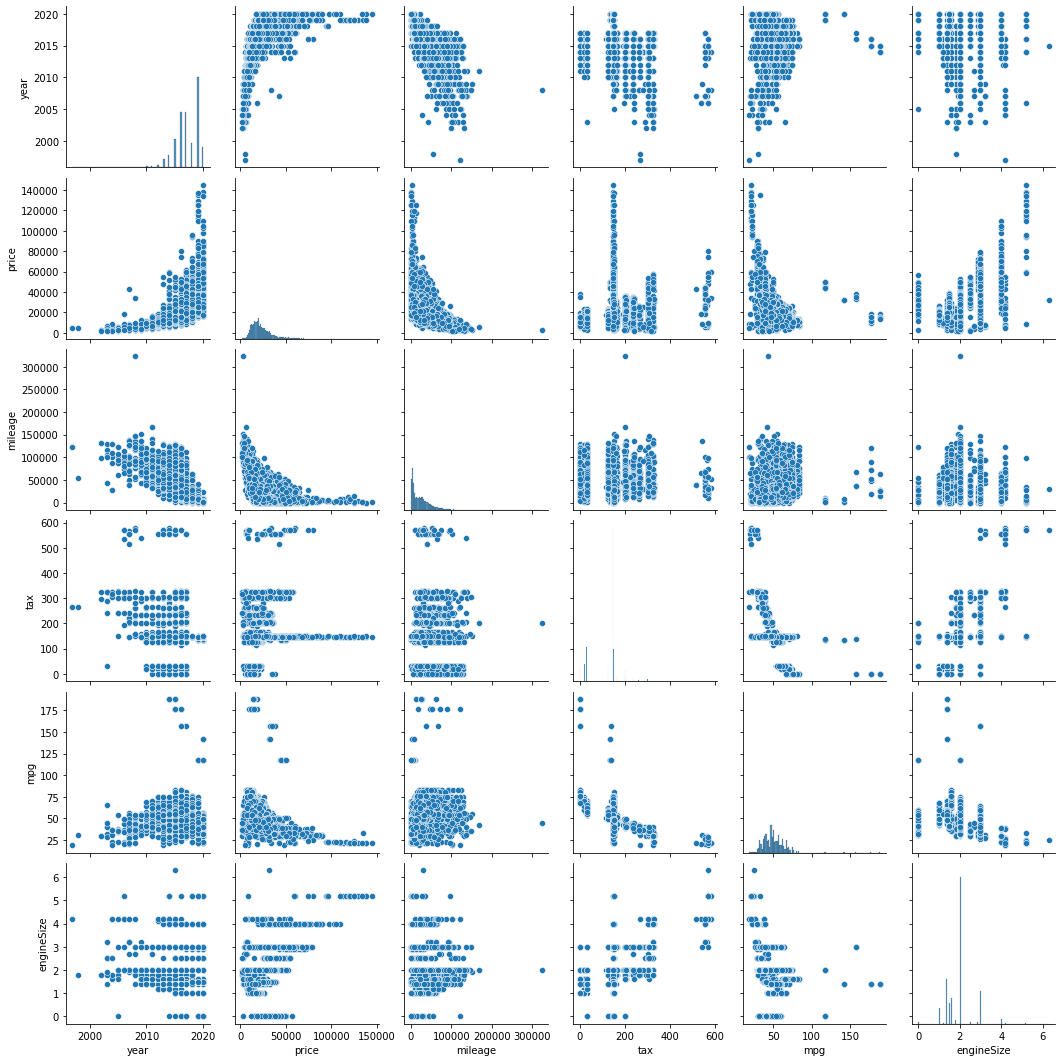

In [42]:
# Pairplotting to view the insights
sns.pairplot(data)
plt.show()

<AxesSubplot:>

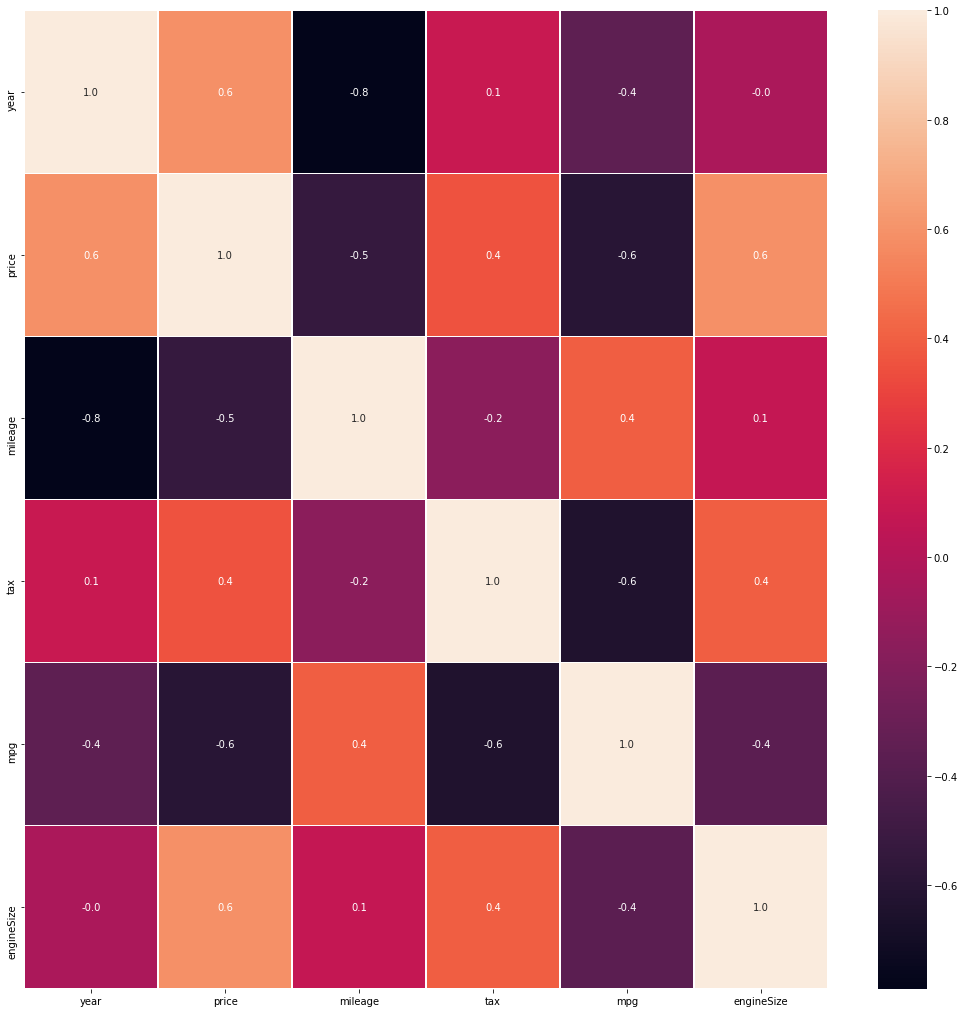

In [43]:
# The correlation between the features
f, ax = plt.subplots(figsize=(18,18))
sns.heatmap(data.corr(), annot=True, linewidth=.5, fmt='.1f', ax=ax)

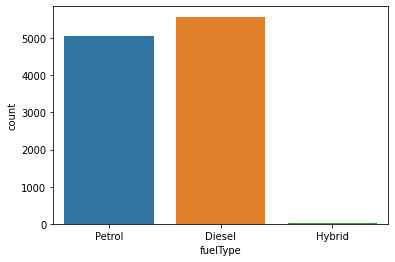

In [44]:
# Count plot on fuel type
ax = sns.countplot(data.fuelType, label = "Count")

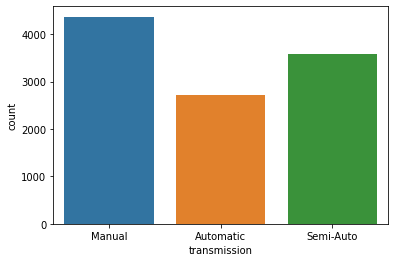

In [45]:
# Count plot on the transmission
ax = sns.countplot(data.transmission, label = "Count")

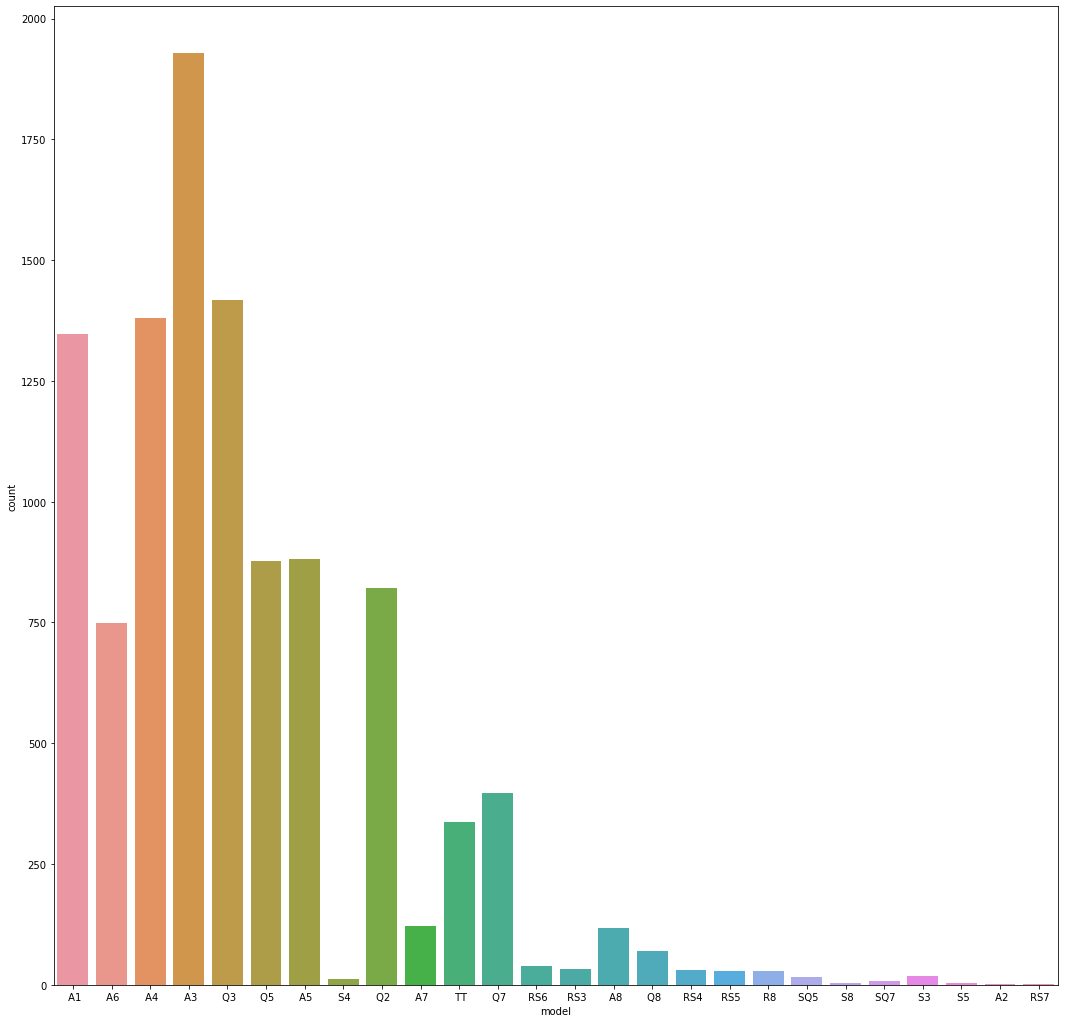

In [46]:
# Count plot on model
plt.subplots(figsize=(18,18))
ax = sns.countplot(data.model, label = "Count")

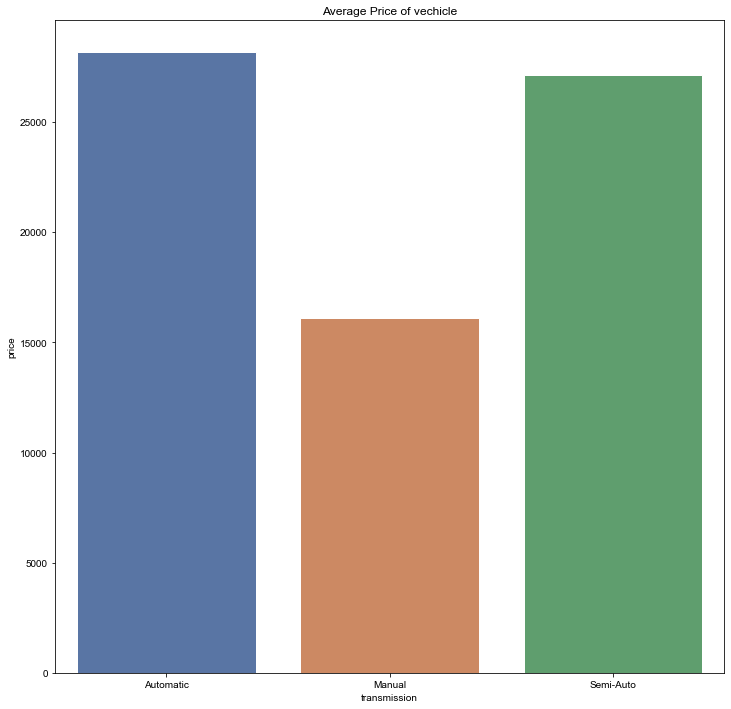

In [47]:
# Checking the price of car by transimission type
plt.subplots(figsize=(12,12))
price_by_transmission = data.groupby("transmission")['price'].mean().reset_index()
plt.title("Average Price of vechicle")
sns.set()
sns.barplot(x="transmission", y ="price", data = price_by_transmission)
plt.show()

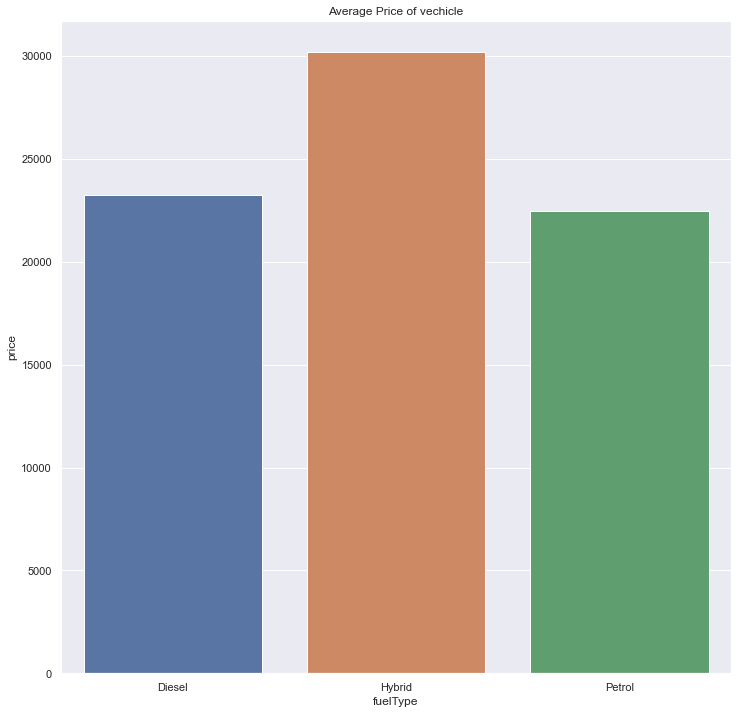

In [48]:
# Checking the price by fueltype
plt.subplots(figsize=(12,12))
price_by_fuel = data.groupby("fuelType")['price'].mean().reset_index()
plt.title("Average Price of vechicle")
sns.set()
sns.barplot(x="fuelType", y ="price", data = price_by_fuel)
plt.show()

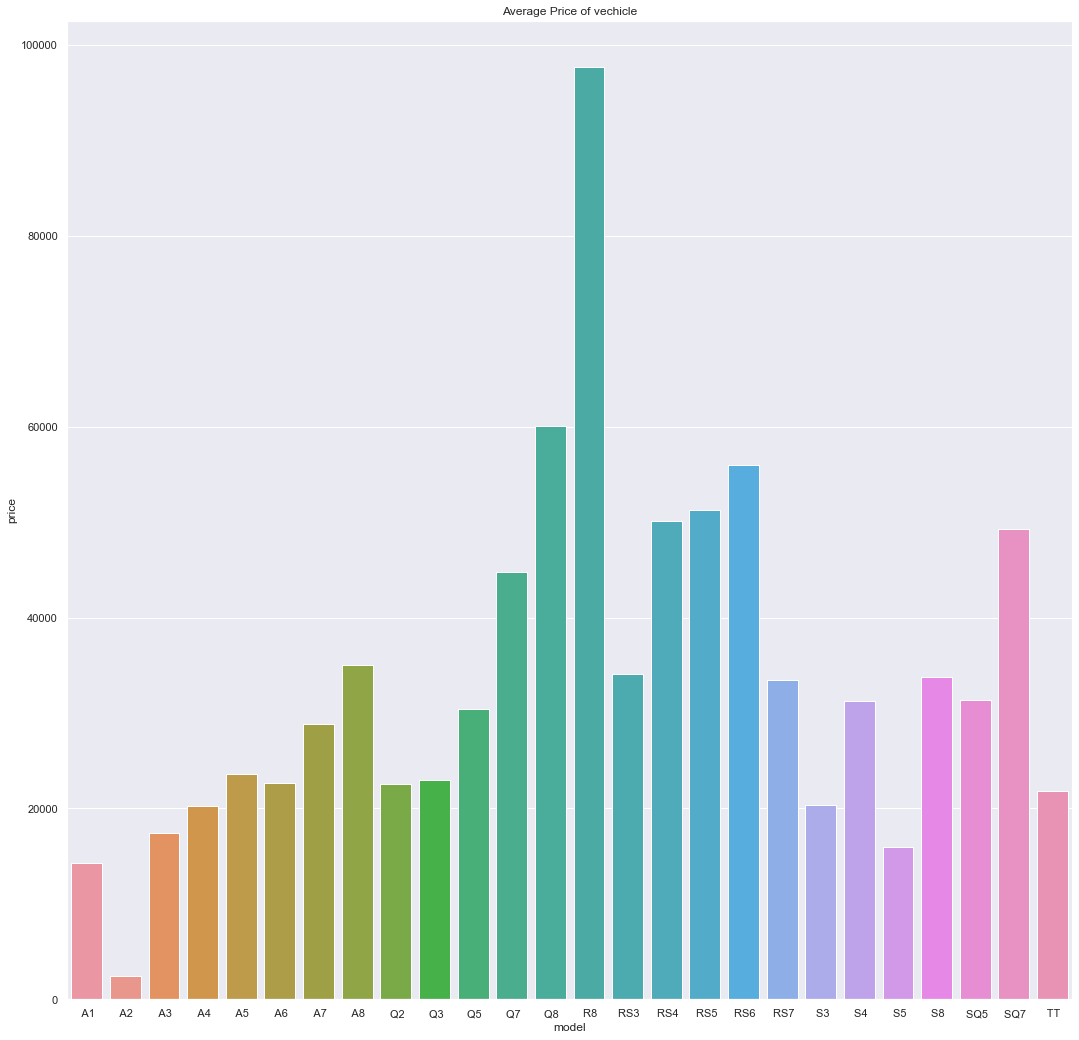

In [49]:
# Checking the price by model
plt.subplots(figsize=(18,18))
price_by_model = data.groupby("model")['price'].mean().reset_index()
plt.title("Average Price of vechicle")
sns.set()
sns.barplot(x="model", y ="price", data = price_by_model)
plt.show()

In [51]:
# Feature engineering
final_data = pd.concat([data,pd.get_dummies(data.fuelType), pd.get_dummies(data.transmission)], axis =1)

In [52]:
final_data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Diesel,Hybrid,Petrol,Automatic,Manual,Semi-Auto
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,0,0,1,0,1,0
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,1,0,0,1,0,0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,0,0,1,0,1,0
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,1,0,0,1,0,0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,0,0,1,0,1,0


In [53]:
final_data = final_data.drop(["transmission", "fuelType", "model"], axis = 1)

In [54]:
# Fitting Regression Model
X = final_data.drop("price", axis = 1)
y = final_data["price"]

In [55]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=100)

In [56]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [57]:
X_train_new = X_train
X_train_new = sm.add_constant(X_train_new)

In [58]:
lr_1 = sm.OLS(y_train,X_train_new).fit()
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     3442.
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        13:17:18   Log-Likelihood:                -74402.
No. Observations:                7467   AIC:                         1.488e+05
Df Residuals:                    7457   BIC:                         1.489e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.211e+06   5.71e+04    -38.736      0.0

In [59]:
from sklearn import preprocessing
def normalize(x):
    return ((x-np.min(x))/(max(x)-min(x)))

final_data = final_data.apply(normalize)

In [60]:
# After Normalizing
final_data.head()

,year,price,mileage,tax,mpg,engineSize,Diesel,Hybrid,Petrol,Automatic,Manual,Semi-Auto
0,0.869565,0.076719,0.048712,0.258621,0.215466,0.222222,0.0,0.0,1.0,0.0,1.0,0.0
1,0.826087,0.104592,0.112081,0.034483,0.267414,0.317460,1.0,0.0,0.0,1.0,0.0,0.0
2,0.826087,0.066267,0.092709,0.051724,0.215466,0.222222,0.0,0.0,1.0,0.0,1.0,0.0
3,0.869565,0.106682,0.080344,0.250000,0.285714,0.317460,1.0,0.0,0.0,1.0,0.0,0.0
4,0.956522,0.110167,0.006183,0.250000,0.181228,0.158730,0.0,0.0,1.0,0.0,1.0,0.0


In [61]:
X = final_data.drop('price',axis=1)
y =  final_data['price']

In [62]:
# Splitting the data
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=100)
forest_X_train = X_train.copy()
forest_X_test = X_test.copy()
forest_y_train = y_train.copy()
forest_y_test = y_test.copy()

In [63]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [64]:
X_train_new = X_train
X_train_new = sm.add_constant(X_train_new)
lr_2 = sm.OLS(y_train,X_train_new).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     3442.
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        13:19:14   Log-Likelihood:                 14262.
No. Observations:                7467   AIC:                        -2.850e+04
Df Residuals:                    7457   BIC:                        -2.843e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0148      0.006     -2.384      0.0

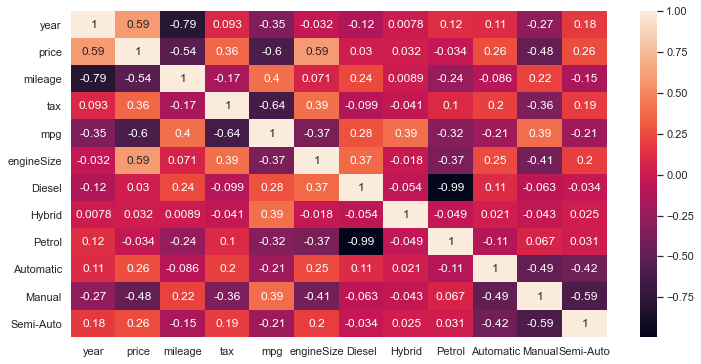

In [65]:
plt.figure(figsize=(12,6))
sns.heatmap(final_data.corr(),annot=True)
plt.show()

In [66]:
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [67]:
vif_cal(input_data=final_data,dependent_col='price')

,Var,Vif
5,Diesel,inf
6,Hybrid,inf
7,Petrol,inf
8,Automatic,inf
9,Manual,inf
10,Semi-Auto,inf
3,mpg,4.05
0,year,2.93
1,mileage,2.92
2,tax,2.05


In [68]:
# dropping automatic column because p-value is high and also VIF is high too
X_train = X_train.drop('Automatic',axis=1)
lr_3 = sm.OLS(y_train,X_train).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     3442.
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        13:20:28   Log-Likelihood:                 14262.
No. Observations:                7467   AIC:                        -2.850e+04
Df Residuals:                    7457   BIC:                        -2.843e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.2961      0.008     39.308      0.0

In [69]:
vif_cal(input_data=final_data.drop(['Automatic'],axis=1),dependent_col='price')

,Var,Vif
5,Diesel,248.57
7,Petrol,205.46
3,mpg,4.05
6,Hybrid,3.64
0,year,2.93
1,mileage,2.92
2,tax,2.05
8,Manual,2.03
4,engineSize,2.02
9,Semi-Auto,1.56


In [70]:
# dropping Diesel because p-value is high and also VIF is high too
X_train = X_train.drop('Diesel',1)
lr_4 = sm.OLS(y_train,X_train).fit()

print(lr_4.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.759e+04
Date:                Tue, 04 May 2021   Prob (F-statistic):                        0.00
Time:                        13:21:03   Log-Likelihood:                          14181.
No. Observations:                7467   AIC:                                 -2.834e+04
Df Residuals:                    7458   BIC:                                 -2.828e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [71]:
vif_cal(input_data=final_data.drop(['Automatic','Diesel'],axis=1),dependent_col='price')

,Var,Vif
0,year,48.38
3,mpg,20.05
4,engineSize,18.72
2,tax,7.76
1,mileage,4.16
7,Manual,3.34
6,Petrol,2.77
8,Semi-Auto,2.36
5,Hybrid,1.39


In [72]:
# Making predictions
X_test_m4 = sm.add_constant(X_test)

In [73]:
X_test_m4 = X_test.drop(['Automatic', 'Diesel'],axis=1)
y_pred_m4 = lr_4.predict(X_test_m4)

In [74]:
from sklearn.metrics import r2_score,mean_squared_error
print('R square:',r2_score(y_test,y_pred_m4))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_m4)))

R square: 0.7860703110866781
RMSE: 0.03803308788779116


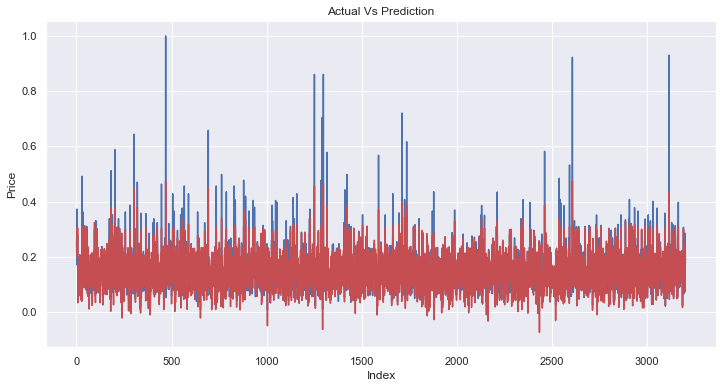

In [75]:
plt.figure(figsize=(12,6))
c = [i for i in range(1,len(X_test_m4)+1,1)]
plt.plot(c,y_test,linestyle='-',color='b')
plt.plot(c,y_pred_m4,linestyle='-',color='r')
plt.title('Actual Vs Prediction')
plt.xlabel('Index')
plt.ylabel('Price')
plt.show()

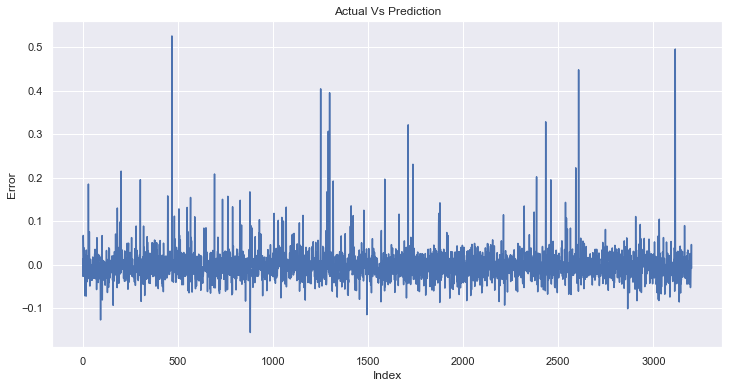

In [76]:
# Error
plt.figure(figsize=(12,6))
c = [i for i in range(1,len(X_test_m4)+1,1)]
plt.plot(c,y_test-y_pred_m4,linestyle='-',color='b')
#plt.plot(c,y_pred_m6,linestyle='-',color='r')
plt.title('Actual Vs Prediction')
plt.xlabel('Index')
plt.ylabel('Error')
plt.show()

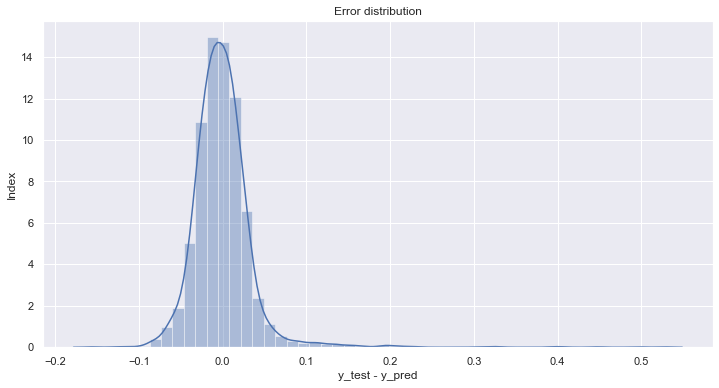

In [77]:
# Error Distribution
plt.figure(figsize=(12,6))
sns.distplot(y_test-y_pred_m4,bins=50)
plt.xlabel('y_test - y_pred')
plt.ylabel('Index')
plt.title('Error distribution')
plt.show()

In [78]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
forest.fit(forest_X_train,forest_y_train)

RandomForestRegressor()

In [79]:
forest_y_pred = forest.predict(forest_X_test)

In [80]:
# Calculating RMSE
forest_rmse = np.sqrt(mean_squared_error(forest_y_test,forest_y_pred))
forest_r2score = r2_score(forest_y_test,forest_y_pred)
print("R2 score is ", forest_r2score)
print("rmse is ", forest_rmse )

R2 score is  0.9494694753731929
rmse is  0.018484297970523603


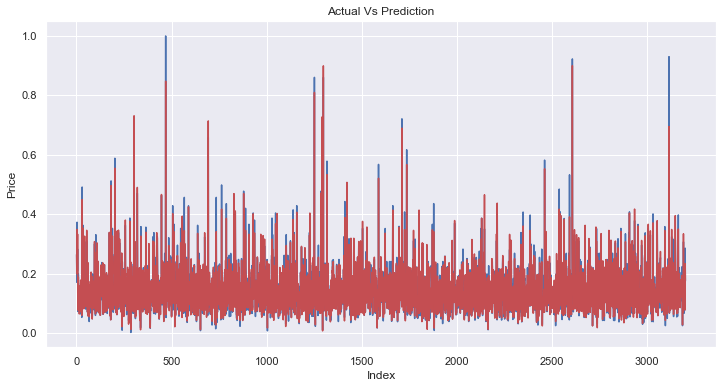

In [81]:
# Model evaluation
plt.figure(figsize=(12,6))
c = [i for i in range(1,len(forest_X_test)+1,1)]
plt.plot(c,forest_y_test,linestyle='-',color='b')
plt.plot(c,forest_y_pred,linestyle='-',color='r')
plt.title('Actual Vs Prediction')
plt.xlabel('Index')
plt.ylabel('Price')
plt.show()

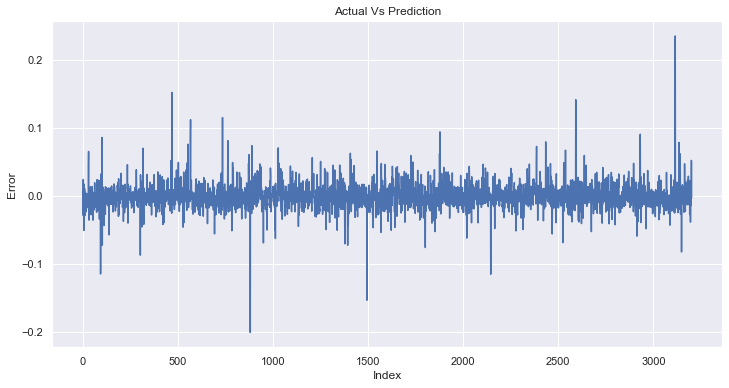

In [82]:
# Error
plt.figure(figsize=(12,6))
c = [i for i in range(1,len(forest_X_test)+1,1)]
plt.plot(c,forest_y_test-forest_y_pred,linestyle='-',color='b')
#plt.plot(c,y_pred_m6,linestyle='-',color='r')
plt.title('Actual Vs Prediction')
plt.xlabel('Index')
plt.ylabel('Error')
plt.show()

In [83]:
# Decision tree regressor
from sklearn.tree import DecisionTreeRegressor
tree=DecisionTreeRegressor()
tree.fit(forest_X_train.drop(['Automatic','Diesel'], axis=1),forest_y_train)

DecisionTreeRegressor()

In [84]:
tree_y_pred = tree.predict(forest_X_test.drop(['Automatic', 'Diesel'], axis = 1))

In [85]:
# Calculating RMSE
forest_rmse = np.sqrt(mean_squared_error(forest_y_test,tree_y_pred))
forest_r2score = r2_score(forest_y_test,tree_y_pred)
print("R2 score is ", forest_r2score)
print("rmse is ", forest_rmse )

R2 score is  0.9202843017166671
rmse is  0.02321656608522494
